# Дисбаланс выборки

**Несбалансированная выборка (imbalanced dataset)** — выборка, в которой количество примеров каких-то классов сильно превалирует над количеством примеров других классов. Это определение также можно расширить на другие типы задач. Например, в задаче регрессии дисбалансом выборки будет ситуация, при которой распределение целевых значений будет сильно отличаться от равномерного.

## Когда считать выборку несбалансированной?

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


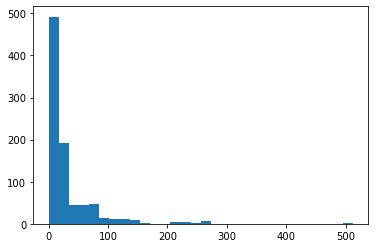

In [3]:
plt.hist(titanic['Fare'], bins=30);

<AxesSubplot:xlabel='Survived', ylabel='count'>

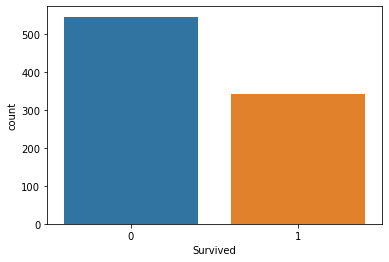

In [4]:
sns.countplot(x='Survived', data=titanic)

Нет точного определения, когда считать выборку несбалансированной. Неформально считается, что выборка несбалансированна, когда отношение количества преобладающего и минорного классов составляет 10:1.

## Последствия дисбаланса данных

Что происходит при дисбалансе классов:
1. У алгоритма появляется склонность к более популярным классам/значениям.
1. Невозможность использования метрик, не учитывающих веса классов (базовая метрика accuracy, изученная выше, не может быть использована).

## Решение проблемы

1. Изменить целевую метрику — в задачах классификации confusion matrix, precision, recall, F1-score, ROC-кривые будут намного корректнее описывать алгоритм, чем accuracy.
1. Изменить выборку данных: 1) oversampling — увеличение кол-ва объектов классов-меньшинств; 2) undersampling — сокращение кол-ва объектов превалирующих классов.
1. Добавить штраф в оптимизационный функционал, прямо пропорциональный кол-ву объектов каждого класса (веса классов).
1. Возможно, есть смысл перейти к задачам [Anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection) и [Change detection](https://en.wikipedia.org/wiki/Change_detection).

Во 2-м способе решение проблемы oversampling может быть выполнено как простым дублированием примеров меньшего класса, так и и более сложной техникой, называемой "аугментацией выборки".

**Аугментация выборки (data augmentation)** — процесс генерации примеров из исходных путем их модификации. Примерами аугментации данных могут служить: повороты, масштабирование изображений, применение фильтров; для текста может быть незначительно изменен контекст и изменено склонение/спряжение слов.

Еще одна техника, которая может быть использована для oversampling это **обогащение данных**. При использовании этой техники данные находятся во внешних дополнительных источниках. Например, если банк решает свою скоринговую задачу, он может также расширить свой набор данных данными другого банка при их наличии.